In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
import math
import matplotlib.pyplot as plt

In [116]:
def get_real_MJ(x):
   
    accept = []
    T = 1

    X_accept = []
    y_reject = []

    X = np.random.rand(10*x,4)
    #print(X)
    
    
    for i in range(len(X)):
        
    
            
                
            
            u = T*(-np.log(X[i,0]) - np.log(X[i,1]) - np.log(X[i,2]))
            if X[i,3] < math.exp((u - math.sqrt(1+(u**2)))/T) and len(accept)<x:


                number = u.tolist()
                
                accept.append(number-0.3)
                #print(len(accept))
                
    accept = torch.Tensor(accept)
    accept = accept.reshape(1,-1)
    accept = accept
        
                
    return accept.requires_grad_()


    

In [117]:
Series_Length = 30
g_input_size = 20    
g_hidden_size = 150  
g_output_size = Series_Length

In [118]:
d_input_size = Series_Length
d_hidden_size = 75  
d_output_size = 1

In [119]:
d_minibatch_size = 15 
g_minibatch_size = 10

num_epochs = 600000
print_interval = 100

d_learning_rate = 3e-3
g_learning_rate = 8e-3

def get_real_sampler(mu, sigma):
    dist = Normal( mu, sigma )
    return lambda m, n: dist.sample( (m, n) ).requires_grad_()

def get_noise_sampler():
    return lambda m, n: torch.rand(m, n).requires_grad_()  # Uniform-dist data into generator, _NOT_ Gaussian

#actual_data = get_real_sampler( data_mean, data_stddev )
noise_data  = get_noise_sampler()

In [125]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, hidden_size)
        self.map4 = nn.Linear(hidden_size, hidden_size)
        
        self.map5 = nn.Linear(hidden_size, output_size)
              
        
        
        

        self.xfer = torch.nn.SELU()
        self.xfer_2 = torch.nn.SiLU()

    def forward(self, x):
        x = self.xfer( self.map1(x) )
        x = self.xfer( self.map2(x) )
        x = self.xfer( self.map3(x) )
        x = self.xfer( self.map4(x) )
        
      
     
       
        
    
        return self.xfer( self.map5( x ) )

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, hidden_size)
        
        
        self.map4 = nn.Linear(hidden_size, output_size)
        self.elu = torch.nn.ELU()

    def forward(self, x):
        x = self.elu(self.map1(x))
        x = self.elu(self.map2(x))
        x = self.elu(self.map3(x))
        
        
        return torch.sigmoid( self.map4(x) )

In [127]:
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)


In [128]:
criterion = nn.BCELoss()
d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate ) #, betas=optim_betas)
g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate ) #, betas=optim_betas)

In [129]:
def train_D_on_actual() :
    #real_data = actual_data( d_minibatch_size, d_input_size )
    u = d_minibatch_size*d_input_size
    actual_data = get_real_MJ(u)
    
    #real_data = actual_data(d_minibatch_size,d_input_size)
    real_data = torch.Tensor(actual_data).reshape(d_minibatch_size,d_input_size)
    decision = D( real_data )
    error = criterion( decision, torch.ones( d_minibatch_size, 1 ))  # ones = true
    error.backward() 

In [130]:
def train_D_on_generated() :
    noise = noise_data( d_minibatch_size, g_input_size )
    fake_data = G( noise ) 
    decision = D( fake_data )
    error = criterion( decision, torch.zeros( d_minibatch_size, 1 ))  # zeros = fake
    error.backward()

In [131]:
def train_G():
    noise = noise_data( g_minibatch_size, g_input_size )
    fake_data = G( noise )
    fake_decision = D( fake_data )
    error = criterion( fake_decision, torch.ones( g_minibatch_size, 1 ) )  # we want to fool, so pretend it's all genuine

    error.backward()
    return error.item(), fake_data

In [132]:
losses = []

for epoch in range(num_epochs):
    D.zero_grad()
    
    train_D_on_actual()    
    train_D_on_generated()
    d_optimizer.step()
    
    G.zero_grad()
    loss,generated = train_G()
    g_optimizer.step()
    
    losses.append( loss )
    if( epoch % print_interval) == (print_interval-1) :
        print( "Epoch %6d. Loss %5.3f" % ( epoch+1, loss ) )
        
print( "Training complete" )

Epoch    100. Loss 0.699
Epoch    200. Loss 0.605
Epoch    300. Loss 0.803
Epoch    400. Loss 0.586
Epoch    500. Loss 0.874
Epoch    600. Loss 1.090
Epoch    700. Loss 0.935
Epoch    800. Loss 0.956
Epoch    900. Loss 0.795
Epoch   1000. Loss 0.649
Epoch   1100. Loss 0.714
Epoch   1200. Loss 0.689
Epoch   1300. Loss 0.600
Epoch   1400. Loss 0.901
Epoch   1500. Loss 0.786
Epoch   1600. Loss 0.678
Epoch   1700. Loss 0.715
Epoch   1800. Loss 0.808
Epoch   1900. Loss 0.668
Epoch   2000. Loss 0.736
Epoch   2100. Loss 0.730
Epoch   2200. Loss 0.654
Epoch   2300. Loss 0.840
Epoch   2400. Loss 0.730
Epoch   2500. Loss 0.757
Epoch   2600. Loss 0.765
Epoch   2700. Loss 0.768
Epoch   2800. Loss 0.635
Epoch   2900. Loss 0.741
Epoch   3000. Loss 0.847
Epoch   3100. Loss 0.785
Epoch   3200. Loss 0.611
Epoch   3300. Loss 0.689
Epoch   3400. Loss 0.705
Epoch   3500. Loss 0.741
Epoch   3600. Loss 0.779
Epoch   3700. Loss 0.868
Epoch   3800. Loss 0.559
Epoch   3900. Loss 0.749
Epoch   4000. Loss 0.807


Epoch  32900. Loss 7.667
Epoch  33000. Loss 7.675
Epoch  33100. Loss 7.683
Epoch  33200. Loss 7.691
Epoch  33300. Loss 7.698
Epoch  33400. Loss 7.706
Epoch  33500. Loss 7.713
Epoch  33600. Loss 7.721
Epoch  33700. Loss 7.729
Epoch  33800. Loss 7.736
Epoch  33900. Loss 7.743
Epoch  34000. Loss 7.751
Epoch  34100. Loss 7.758
Epoch  34200. Loss 7.765
Epoch  34300. Loss 7.773
Epoch  34400. Loss 7.780
Epoch  34500. Loss 7.787
Epoch  34600. Loss 7.794
Epoch  34700. Loss 7.801
Epoch  34800. Loss 7.808
Epoch  34900. Loss 7.815
Epoch  35000. Loss 7.822
Epoch  35100. Loss 7.829
Epoch  35200. Loss 7.836
Epoch  35300. Loss 7.842
Epoch  35400. Loss 7.849
Epoch  35500. Loss 7.856
Epoch  35600. Loss 7.863
Epoch  35700. Loss 7.869
Epoch  35800. Loss 7.876
Epoch  35900. Loss 7.882
Epoch  36000. Loss 7.889
Epoch  36100. Loss 7.895
Epoch  36200. Loss 7.902
Epoch  36300. Loss 7.908
Epoch  36400. Loss 7.915
Epoch  36500. Loss 7.921
Epoch  36600. Loss 7.927
Epoch  36700. Loss 7.934
Epoch  36800. Loss 7.940


Epoch  65700. Loss 9.019
Epoch  65800. Loss 9.022
Epoch  65900. Loss 9.024
Epoch  66000. Loss 9.027
Epoch  66100. Loss 9.029
Epoch  66200. Loss 9.032
Epoch  66300. Loss 9.034
Epoch  66400. Loss 9.036
Epoch  66500. Loss 9.039
Epoch  66600. Loss 9.041
Epoch  66700. Loss 9.043
Epoch  66800. Loss 9.046
Epoch  66900. Loss 9.048
Epoch  67000. Loss 9.051
Epoch  67100. Loss 9.053
Epoch  67200. Loss 9.055
Epoch  67300. Loss 9.058
Epoch  67400. Loss 9.060
Epoch  67500. Loss 9.062
Epoch  67600. Loss 9.065
Epoch  67700. Loss 9.067
Epoch  67800. Loss 9.069
Epoch  67900. Loss 9.072
Epoch  68000. Loss 9.074
Epoch  68100. Loss 9.076
Epoch  68200. Loss 9.079
Epoch  68300. Loss 9.081
Epoch  68400. Loss 9.083
Epoch  68500. Loss 9.086
Epoch  68600. Loss 9.088
Epoch  68700. Loss 9.090
Epoch  68800. Loss 9.093
Epoch  68900. Loss 9.095
Epoch  69000. Loss 9.097
Epoch  69100. Loss 9.099
Epoch  69200. Loss 9.102
Epoch  69300. Loss 9.104
Epoch  69400. Loss 9.106
Epoch  69500. Loss 9.108
Epoch  69600. Loss 9.111


Epoch  98500. Loss 9.617
Epoch  98600. Loss 9.619
Epoch  98700. Loss 9.620
Epoch  98800. Loss 9.622
Epoch  98900. Loss 9.623
Epoch  99000. Loss 9.625
Epoch  99100. Loss 9.626
Epoch  99200. Loss 9.628
Epoch  99300. Loss 9.629
Epoch  99400. Loss 9.631
Epoch  99500. Loss 9.632
Epoch  99600. Loss 9.634
Epoch  99700. Loss 9.635
Epoch  99800. Loss 9.636
Epoch  99900. Loss 9.638
Epoch 100000. Loss 9.639
Epoch 100100. Loss 9.641
Epoch 100200. Loss 9.642
Epoch 100300. Loss 9.644
Epoch 100400. Loss 9.645
Epoch 100500. Loss 9.647
Epoch 100600. Loss 9.648
Epoch 100700. Loss 9.649
Epoch 100800. Loss 9.651
Epoch 100900. Loss 9.652
Epoch 101000. Loss 9.654
Epoch 101100. Loss 9.655
Epoch 101200. Loss 9.657
Epoch 101300. Loss 9.658
Epoch 101400. Loss 9.659
Epoch 101500. Loss 9.661
Epoch 101600. Loss 9.662
Epoch 101700. Loss 9.664
Epoch 101800. Loss 9.665
Epoch 101900. Loss 9.667
Epoch 102000. Loss 9.668
Epoch 102100. Loss 9.669
Epoch 102200. Loss 9.671
Epoch 102300. Loss 9.672
Epoch 102400. Loss 9.674


KeyboardInterrupt: 

In [113]:
Generated_samples = []
for i in range(10000):
    noise = noise_data( g_minibatch_size, g_input_size )
    fake_data = G( noise )
    Generated_samples.append(fake_data.flatten().tolist())
    
TF = np.empty([10000,300])
for i in range(len(Generated_samples)):
    TF[i] = Generated_samples[i]

In [65]:
v = get_real_MJ(10000*300)
v = torch.Tensor(v)

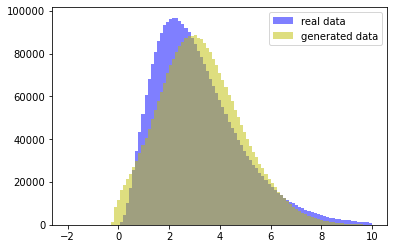

In [177]:
from matplotlib import pyplot
pyplot.hist(v.tolist(),np.linspace(-2,10,100),alpha = 0.5, color = 'b', label = 'real data')
pyplot.hist(JF.flatten()[JF.flatten()>-0.2],np.linspace(-2,10,100),np.linspace(-2,3,100),alpha = 0.5, color = 'y',label = 'generated data')
pyplot.legend(loc='upper right')
pyplot.show()

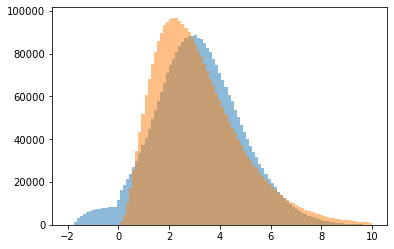

In [172]:
plt.hist(JF.reshape(1,-1).tolist(),np.linspace(-2,10,100),alpha=0.5)
plt.hist(v.tolist(),np.linspace(-2,10,100),alpha=0.5)
plt.show()

In [ ]:
import pylab as plt
import numpy as np

Z =   G.reshape(150,200)
plt.imshow(Z, cmap='gray', interpolation='nearest')
plt.show()

In [187]:
from statsmodels.sandbox.stats.runs import runstest_1samp 

In [190]:
print(JF.flatten()[JF.flatten()>-0.2].reshape(1,-1)[:,:10000])

[[2.84320927 5.05913782 3.00125432 ... 1.59787929 2.70986104 3.61600161]]
